In [4]:
using ChangesOfVariables, InverseFunctions, ArraysOfArrays, Statistics
using Optimisers
using PyPlot
using Distributions
using LinearAlgebra
using Test

# using ForwardDiff
# using ReverseDiff
using FiniteDifferences

using Revise
using EuclidianNormalizingFlows

In [5]:
# Compare transformation results & gradients using Finite Differences and and handwritten pullbacks.

function run_test_suite(; nrepetitions = 20,
        ndims = 8,
        nparams = 5,
        nsmpls = 15,
        dist = Uniform(-3, 3),
    )
    
    for i in 1:nrepetitions
        
        algo = central_fdm(5, 1)
        rtol = 0.001

        w = rand(dist, ndims, nparams)
        h = rand(dist, ndims, nparams)
        d = rand(dist, ndims, nparams-1)
        x = rand(Normal(0, 5), ndims, nsmpls)
        
        try 
            
            trafo_frwd = RationalQuadSpline(w,h,d)
            trafo_bcwd = RationalQuadSplineInv(w,h,d)

            x_fwd, jac_frwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_frwd, x)
            x_bcwd, jac_bcwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_bcwd, x_fwd) 

            @test x_bcwd ≈ x
            @test jac_frwd ≈ -jac_bcwd

            for j in 1:size(x, 2)
                xrun = x[:,j]
                autodiff_jac = FiniteDifferences.jacobian(algo, xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )[1]
                @test isapprox.(log(abs(det(autodiff_jac))), jac_frwd[1,j], rtol = rtol)
                @test isapprox.(log(abs(det(autodiff_jac))), -jac_bcwd[1, j], rtol = rtol)
            end

            neg_ll, gradvals = EuclidianNormalizingFlows.mvnormal_negll_trafograd(trafo_frwd, x)

            a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(par,h,d), x), w)[1]
            @test isapprox(a_run, gradvals.widths, rtol = rtol)

            a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,par,d), x), h)[1]
            @test isapprox(a_run, gradvals.heights, rtol = rtol)

            a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,h,par), x), d)[1]
            @test isapprox(a_run, gradvals.derivatives, rtol = rtol)
            
            println("Test no. $i successfull!")
        catch 
            print("Test error. Parameters: \n")
            @show w, h, d, x
        end
        
    end
end

run_test_suite()

Test no. 1 successfull!
Test no. 2 successfull!
Test no. 3 successfull!
Test no. 4 successfull!
Test no. 5 successfull!
Test no. 6 successfull!
Test no. 7 successfull!
Test no. 8 successfull!
Test no. 9 successfull!
Test no. 10 successfull!
Test no. 11 successfull!
Test no. 12 successfull!
Test no. 13 successfull!
Test no. 14 successfull!
Test no. 15 successfull!
Test no. 16 successfull!
Test no. 17 successfull!
Test no. 18 successfull!
Test no. 19 successfull!
Test no. 20 successfull!


# 2D fit: 

In [6]:
nparams = 20
nsmpls = 6000
ndims = 2
K = nparams

dist = Uniform(-1, 1)

trafo_truth = RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

y = rand(Normal(0, 1), ndims, nsmpls)
x = trafo_truth(y);

In [7]:
@test x ≈ RationalQuadSpline(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(RationalQuadSplineInv(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(x))

Test Passed
  Expression: x ≈ (RationalQuadSpline(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))((RationalQuadSplineInv(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))(x))
   Evaluated: [0.524029429671439 0.18205982870946705 … 0.7757753325483407 0.20379128965402638; -0.11703754668809546 2.8168356798398886 … 3.0985736579743524 2.6000422334366675] ≈ [0.5240294296714385 0.18205982870946705 … 0.7757753325483407 0.20379128965402646; -0.11703754668809555 2.816835679839888 … 3.09857365797435 2.600042233436668]

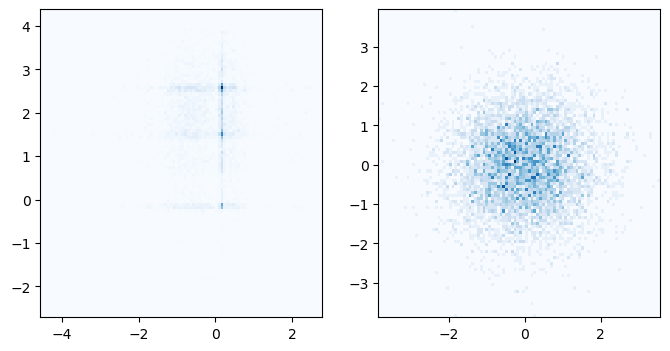

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.8550842965874916, -3.78083280228004, -3.7065813079725887, -3.632329813665137, -3.5580783193576853, -3.483826825050234, -3.4095753307427823, -3.3353238364353306, -3.2610723421278793, -3.186820847820428  …  2.901801685390598, 2.97605317969805, 3.0503046740055013, 3.1245561683129526, 3.1988076626204047, 3.273059156927856, 3.3473106512353072, 3.4215621455427594, 3.4958136398502107, 3.570065134157662], [-3.88292387282771, -3.804513311504191, -3.726102750180672, -3.6476921888571527, -3.569281627533633, -3.490871066210114, -3.412460504886595, -3.334049943563076, -3.255639382239557, -3.1772288209160378  …  3.2524372076125325, 3.3308477689360516, 3.4092583302595707, 3.48766889158309, 3.566079452906609, 3.644490014230128, 3.722900575553647, 3.801311136877166, 3.8797216982006852, 3.9581322595242043], PyObject <matplotlib.collections.QuadMesh object at 0x7fc11bd9b8b0>)

In [8]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [14]:
# initial_trafo = 
#     EuclidianNormalizingFlows.JohnsonTrafo([10.0, 11.0], [3.5, 3.6], [10.0, 11.0], [1.0, 1.1]) ∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo(ones(ndims), zeros(ndims)) ∘  
#     RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

# initial_trafo =  ScaleShiftTrafo(ones(ndims), zeros(ndims))

initial_trafo =  RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

optimizer = ADAGrad()
smpls = nestedview(x)
nbatches = 20
nepochs = 10 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs)

(result = RationalQuadSpline([0.913969253204407 0.91205925607332 … 1.1128549636728484 1.1128549636728484; 1.2627954034388311 1.2627954034388311 … 0.7543756674000796 0.7554497604357127], [1.1670344491789189 1.1730441693584361 … 0.8353263275012278 0.8353263275012278; 0.7618328142948404 0.7618328142948404 … 1.328965980487697 1.3274148306703], [0.955647520139576 2.1506486510683835 … 1.0 1.0; 1.0 1.0 … 0.1762416099424429 0.6798729596598903]), optimizer_state = (widths = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [41.3063 41.1372 … 67.4462 67.4462; 3.9729 3.9729 … 6.1647 6.15507]), heights = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [0.208988 0.206924 … 0.127559 0.127559; 0.165902 0.165902 … 0.624388 0.617268]), derivatives = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [1.8613e-5 0.000133134 … 1.19209e-7 1.19209e-7; 1.19209e-7 1.19209e-7 … 7.63707e-6 1.63235e-6])), negll_history = [4.227033819467336, 3.094417666757815, 2.9699262117502756, 2.642344900095645, 2.4749892695575815, 2.47673561580907, 2.294

In [15]:
yhat = r.result(x)

2×6000 Matrix{Float64}:
  1.34561  0.541574   1.78853   -0.00357251  …  2.05927   1.72269  0.682696
 -1.41709  1.2201    -0.338165  -1.02813        0.615995  1.50864  0.945119

In [11]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2)

mean(yhat, dims = 2) = [-0.019108312901719313; 0.6327864456962604;;]
std(yhat, dims = 2) = [0.8620103231213008; 1.0325879507981843;;]


2×1 Matrix{Float64}:
 0.8620103231213008
 1.0325879507981843

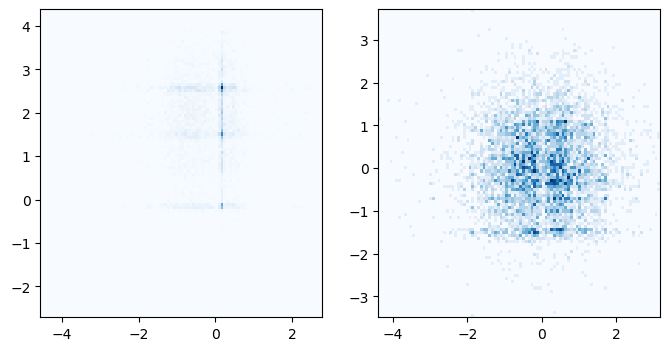

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-4.396979439330223, -4.321144344300852, -4.245309249271481, -4.16947415424211, -4.093639059212739, -4.0178039641833685, -3.9419688691539974, -3.866133774124626, -3.7902986790952555, -3.7144635840658844  …  2.5040142083425314, 2.579849303371902, 2.6556843984012737, 2.7315194934306444, 2.807354588460015, 2.8831896834893866, 2.9590247785187573, 3.034859873548128, 3.1106949685774987, 3.18653006360687], [-3.4904150462120302, -3.4183335239950656, -3.3462520017781006, -3.274170479561136, -3.2020889573441713, -3.1300074351272063, -3.0579259129102416, -2.985844390693277, -2.9137628684763124, -2.8416813462593473  …  3.069003475531763, 3.1410849977487274, 3.213166519965693, 3.2852480421826575, 3.357329564399622, 3.429411086616587, 3.5014926088335514, 3.573574131050516, 3.6456556532674806, 3.7177371754844453], PyObject <matplotlib.collections.QuadMesh object at 0x7fc11ba36250>)

In [16]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

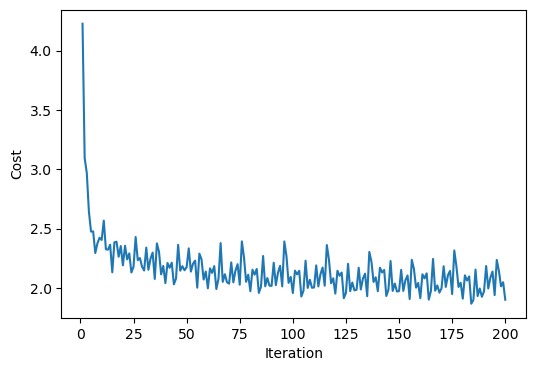

PyObject Text(0.5, 24.0, 'Iteration')

In [17]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")

# 20D fit: 

In [18]:
nparams = 20 # 1180 parameters in total
nsmpls = 6000
ndims = 20
K = nparams
dist = Uniform(-1, 1)

y = rand(Normal(0, 1), ndims, nsmpls);

In [19]:
bwd_true =
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 0.4], [2.5, -1.2]) ∘
#     EuclidianNormalizingFlows.HouseholderTrafo([1.0, 0.3]) ∘
#     EuclidianNormalizingFlows.CenterStretch([1.0, 0.1], [2.0, 2.1], [1.0, 1.1]) ∘
    RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

x = bwd_true(y)

20×6000 Matrix{Float64}:
 -1.68642   -0.255771   -1.56356    …   0.781601  -0.142555    0.715995
 -0.481613  -1.47185    -2.25263       -0.435642  -0.360733   -0.113683
  2.75734    1.52206     3.04342        2.96477    0.328994    1.75138
 -0.261119  -0.996368   -0.989867      -0.483526  -2.12812    -0.36003
 -0.195797  -0.768313   -0.235017      -0.362798   0.382814   -0.73296
 -0.131118  -0.470067   -0.0556402  …  -0.336356  -0.649236    0.952969
  1.16983    0.995714    1.383          1.55921    2.04318    -1.24189
 -1.28402   -1.11207    -2.29019       -1.3154    -0.167515   -1.28429
  1.11974   -0.408333    0.648487      -0.413896   0.913481   -0.0870803
 -0.2937     0.641196   -0.203072      -0.141076  -2.41053     0.147132
 -0.522916  -1.19615     1.02766    …   1.68343   -0.57445     0.78924
 -2.41159   -2.32033    -1.57043       -0.458038  -0.227733   -0.0514676
  0.108875  -0.245456   -0.252636      -0.192557  -1.63293     0.16326
  0.60027   -1.42612    -0.170501       0.49

In [ ]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues");
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [23]:
initial_trafo = 
    RationalQuadSpline(ones(ndims, 40), ones(ndims, 40), ones(ndims, 40-1)) #∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 1], [2., 2]) 

optimizer = ADAGrad(0.1)
smpls = nestedview(x)
nbatches = 50
nepochs = 10 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs);

In [24]:
yhat = r.result(x);

In [ ]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2);

In [ ]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

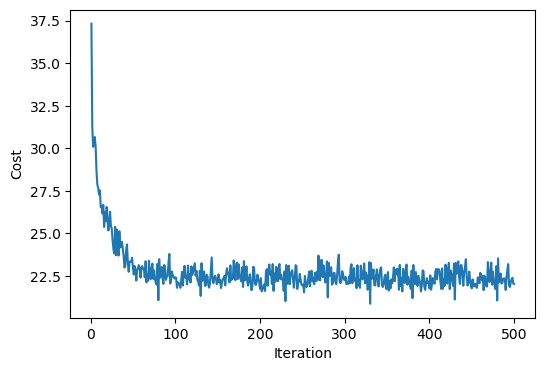

PyObject Text(0.5, 24.0, 'Iteration')

In [25]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")